In [1]:
import sys
import numpy as np
import matplotlib.cm  as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, MeanShift, AgglomerativeClustering, KMeans
from sklearn.preprocessing import scale
import scipy.cluster.hierarchy as sch

sys.path.append('..')
from utils import data_preprocesados, plot_labels, plot_some_LP

La idea de este cuaderno es probar diferentes algoritmos de clustering y ver si somos capaces de separar las señales en varias clases, y comparar las señales de un mismo cluster entre sí. Esto nos va a permitir validad "a ojo" estos modelos y buscar etiquetas manualmente.

In [2]:
X_all = data_preprocesados()

## 1. DBSCAN

Buscando el mejor modelo

In [3]:
outs = []
for s in [1,2,3]:
    eps = []
    scores = []
    for e in np.arange(4,6,0.2):
        dbscan = DBSCAN(eps=e, min_samples=s)
        dbscan.fit(X_all)
        if len(Counter(dbscan.labels_)) > 1:
            score = silhouette_score(X_all, dbscan.labels_)
        else:
            score = -1
        eps.append(e)
        scores.append(score)
    outs.append((eps, scores, s))

In [4]:
max_score = -1
for out in outs:
    score = max(out[1])
    eps = out[0][np.argmax(out[1])]
    min_sample = out[2]

    if score > max_score:
            max_score = score
            best_eps = eps
            best_min_sample = min_sample

print(f'Best performance:: Score: {max_score:.2f} eps: {best_eps:.1f} min_sample: {best_min_sample}')

Best performance:: Score: 0.69 eps: 5.0 min_sample: 2


Counter({0: 1039, -1: 5})


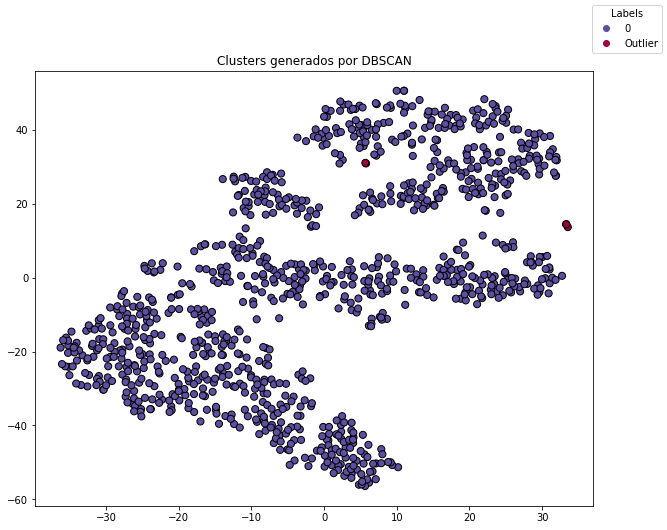

In [5]:
eps = 5
min_samples = 2
dbest = DBSCAN(eps=eps, min_samples=min_samples).fit(X_all)
y_predict = dbest.fit_predict(X_all)

print(Counter(y_predict))

tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(X_all)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_title('Clusters generados por DBSCAN')

labels = list(Counter(y_predict).keys())
norm = mcolors.Normalize(min(labels), max(labels))
cmap = 'Spectral'

for l in labels:
    ax.scatter(X_valid_2D[y_predict==l, 0], X_valid_2D[y_predict==l, 1], norm=norm, cmap=cmap, ec='k', c=y_predict[y_predict==l], marker='o', s=50)

h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap(cmap)(norm(c)), alpha=1) for c in labels]
labels[labels.index(-1)] = 'Outlier'
fig.legend(h, labels, title='Labels')

El mejor modelo me da 1 etiqueta para representar 1039 señales y 5 mal clasificadas (outliers)

-1 [114 482 483 557 631]


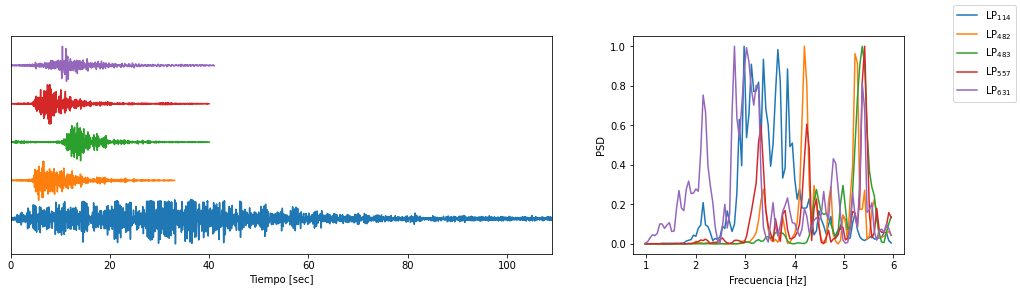

In [6]:
plot_some_LP(y_predict, -1, -1)

Los LPs 485 y 557 podrían llevar la misma etiqueta.

0 [622 630 109]


/home/ifm/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 1024 is greater than input length  = 950, using nperseg = 950
  warnings.warn('nperseg = {0:d} is greater than input length '


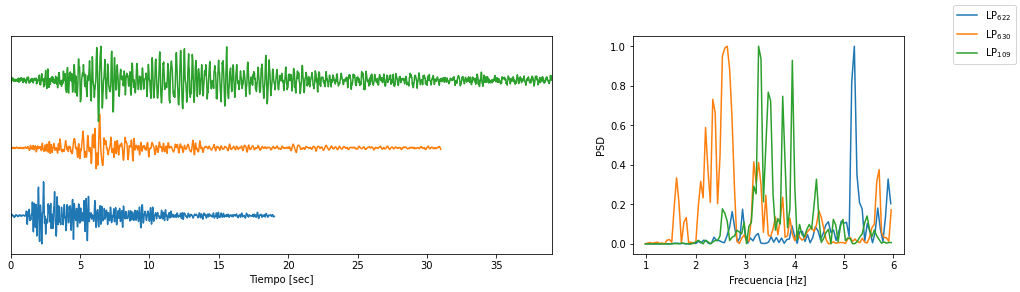

In [8]:
plot_some_LP(y_predict, 0, 3)

No pareciera que estas señales tengan mucho que ver...

## 2.MeanShift

In [9]:
ms = MeanShift(cluster_all=False).fit(X_all)
y_predict = ms.labels_
print('Num. labels:', len(Counter(y_predict)))
print('Score:', silhouette_score(X_all, y_predict))
print(Counter(y_predict))

Num. labels: 14
Score: 0.21932905612489612
Counter({0: 729, -1: 302, 1: 2, 12: 1, 10: 1, 4: 1, 7: 1, 3: 1, 11: 1, 9: 1, 8: 1, 5: 1, 6: 1, 2: 1})


EL  score es muy bajo, las agrupaciones son de a pocos eventos (<10). Muchos outliers (-1:302).

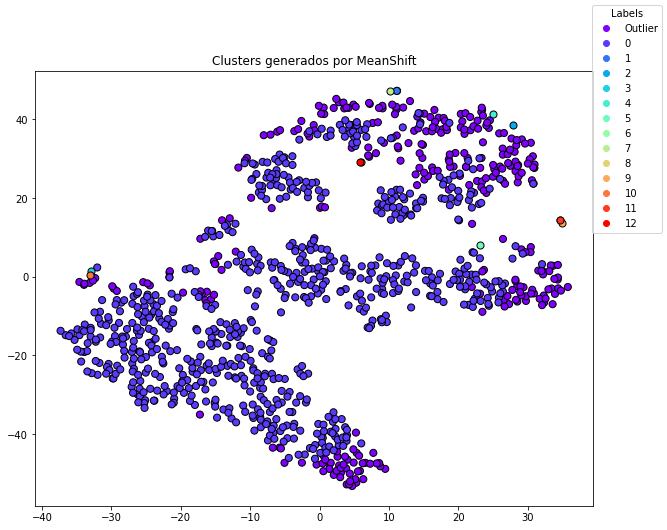

In [10]:
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(X_all)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_title('Clusters generados por MeanShift')

labels = list(Counter(y_predict).keys())
labels.sort()
norm = mcolors.Normalize(min(labels), max(labels))
cmap = 'rainbow'

for l in labels:
    ax.scatter(X_valid_2D[y_predict==l, 0], X_valid_2D[y_predict==l, 1], norm=norm, cmap=cmap, ec='k', c=y_predict[y_predict==l], marker='o', s=50)

h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap(cmap)(norm(c)), alpha=1) for c in labels]
labels[labels.index(-1)] = 'Outlier'
fig.legend(h, labels, title='Labels')


## 3.Hierarchical

In [11]:
print(' linkage ', 'n_cluster', 'score')
for n in (4,5,6,7,8):
    for linkage in ['ward']:
        ms = AgglomerativeClustering(n_clusters=n, linkage=linkage).fit(X_all)
        print(f'{linkage:<8}', f'{n:^9}', f'{silhouette_score(X_all, ms.labels_):^5.2f}')


 linkage  n_cluster score
ward         4     0.22 
ward         5     0.15 
ward         6     0.13 
ward         7     0.15 
ward         8     0.11 


Counter({0: 354, 1: 224, 2: 157, 6: 138, 5: 102, 4: 68, 3: 1})


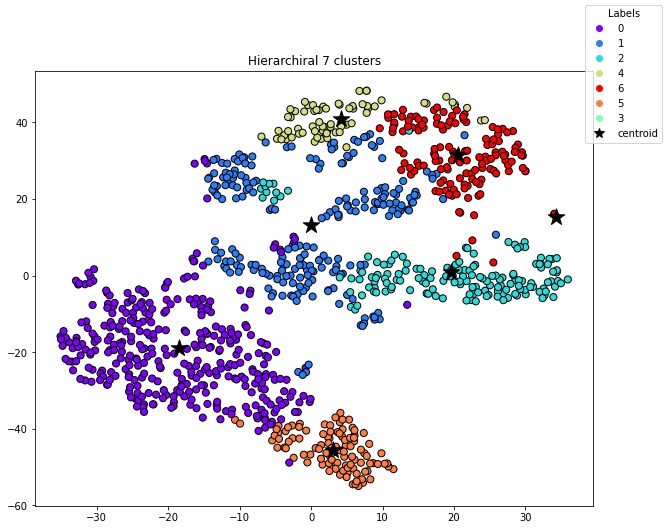

In [12]:
# representar los clusters
n = 7
best_ms = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward').fit(X_all)
y_predict = best_ms.labels_

print(Counter(y_predict))

tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(X_all)

plot_labels(X_valid_2D, y_predict, cmap = 'rainbow', show_centroid=True, title='Hierarchiral %i clusters' %n)

La métrica Silhouete que mejor numero de clusters da, no se corresponde con el gráfico TSNE. Es por ello que la validaión tiene que ser visual mediante este último procedimiento.

In [ ]:
# fig= plt.subplots(1, 1, figsize=(10, 8))
# dendrogram = sch.dendrogram(sch.linkage(X_all, method = 'ward'))
# plt.title('Dendograma')
# plt.xlabel('Clusters')
# plt.ylabel('Distancias Euclidianas')
# plt.show()

# No entiendo el plot del dendograma

Comparemos algunos LPs para algunos labels

4 [702 778 715]


/home/ifm/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 1024 is greater than input length  = 700, using nperseg = 700
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/ifm/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 1024 is greater than input length  = 750, using nperseg = 750
  warnings.warn('nperseg = {0:d} is greater than input length '


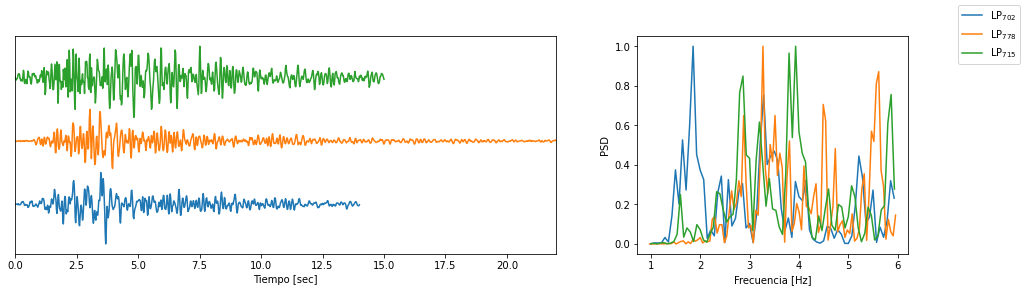

In [13]:
cluster = 4
plot_some_LP(y_predict, cluster, 3)

Este modelo mejora considerablemente las agrupaciones que los anteriores. Sin embargo, no vemos que gráficamente el resultado sea óptimo.
Tampoco vemos que visualmente las señales tengan un especro parecido.

## 4.KMeans

In [14]:
for n_clusters in [5, 6, 7]:
    km = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = km.fit_predict(X_all)
    silhouette_avg = silhouette_score(X_all, cluster_labels)
    print(f'{n_clusters:>6}', f'{silhouette_avg:>10.2f}')
print('')

     5       0.21
     6       0.15
     7       0.15



Counter({1: 237, 0: 209, 6: 203, 2: 177, 5: 135, 3: 82, 4: 1})


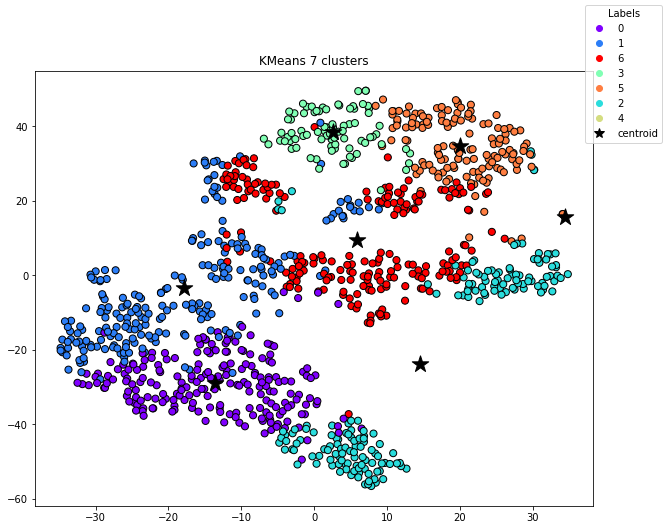

In [15]:
n=7
y_predict = KMeans(n_clusters=n, random_state=0).fit_predict(X_all)
print(Counter(y_predict))

tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(X_all)

plot_labels(X_valid_2D, y_predict, cmap = 'rainbow', show_centroid=True, title='KMeans %i clusters' %n)

2 [576 319 605]


/home/ifm/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 1024 is greater than input length  = 850, using nperseg = 850
  warnings.warn('nperseg = {0:d} is greater than input length '


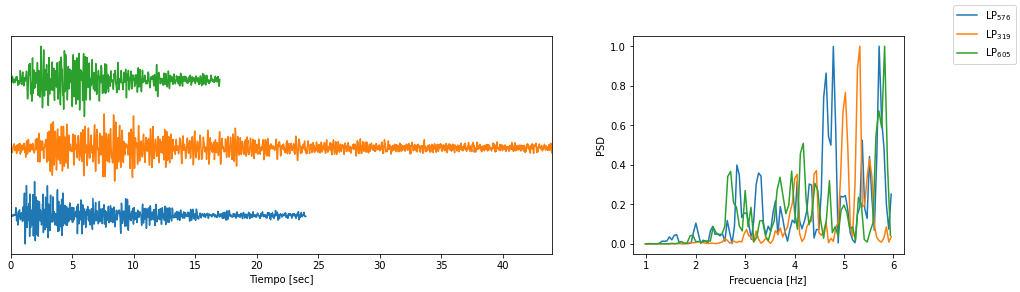

In [16]:
cluster = 2
plot_some_LP(y_predict, cluster, 3)

El Hierarchical se comporta mejor que el KMeans, que no es capaz de agrupar bien algunos puntos en el grafico del TSNE

## Conclusion

Hasta aquí hemos revisado los algorítmos de clustering. Concluimos que el dataset es separable en varios clusters, pero que la métrica Silhouete no se corresponde con la validación visual utilizando reducción TSNE. De todos los métodos el Hierarchical da mejor resultado. Sin embargo, dada la gran cantidad de señales que constituye cada cluster, cuesta mucho esfuerzo poder diferenciar visualmente entre clases.

A continuación, exploraremos algortimos de Mixtura para optimizar la busqueda de acuerdo a la probabilidad de pertenencia de cada clase.